# Wikipedia Event Stream Processing

## Overview

This notebook implements a real-time stream processing job that tracks Wikipedia edit events for five entities from the IMDB dataset. We use the Wikimedia EventStreams API, which provides a continuous stream of events about changes happening across all Wikimedia projects (including Wikipedia).

### Entities Tracked

We track the following five IMDB-related entities:

1. **Christopher Nolan** - Famous director (Inception, The Dark Knight, Interstellar)
2. **The Godfather** - Classic movie, frequently referenced and edited
3. **Quentin Tarantino** - Influential director/writer
4. **Science Fiction** - Genre page with frequent activity
5. **Academy Awards** - Major film awards, high edit activity

### Metrics Collected

For each tracked entity, we collect:
- Total number of edits
- Edit timestamps
- User who made the edit
- Whether the edit was made by a bot
- Size change of the edit (bytes added/removed)

### Alert System

An alert is triggered when:
- **Large edits** occur (> 500 bytes changed) - these could indicate vandalism or major content changes
- **Bot edits** are detected - automated changes that might need review
- **Rapid successive edits** - multiple edits within a short timeframe (potential edit war)

### Output Structure

The system outputs to two JSON files:
1. `wiki_events.json` - All tracked events with metrics
2. `wiki_alerts.json` - Alert events requiring attention

Each event record contains:
```json
{
    "entity": "string - the tracked entity name",
    "timestamp": "ISO 8601 timestamp",
    "user": "string - username who made the edit",
    "is_bot": "boolean - whether the user is a bot",
    "title": "string - Wikipedia page title",
    "comment": "string - edit comment/summary",
    "size_change": "integer - bytes added/removed",
    "wiki": "string - which wiki (e.g., enwiki)",
    "revision_id": "integer - revision ID"
}
```

Alert records additionally contain:
```json
{
    "alert_type": "string - LARGE_EDIT, BOT_EDIT, or RAPID_EDIT",
    "alert_reason": "string - detailed explanation"
}
```

## 1. Setup and Dependencies

First, we install and import the necessary libraries for stream processing.

In [47]:
# Install required packages
%pip install sseclient-py requests python-Levenshtein seaborn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [48]:
import json
import os
from datetime import datetime, timedelta
from collections import defaultdict
import Levenshtein
import requests
from sseclient import SSEClient
import threading
import time

# Fuzzy matching configuration - increased threshold to reduce false positives
FUZZY_MATCH_THRESHOLD = 0.85

print("Dependencies loaded successfully!")
print(f"Fuzzy matching threshold: {FUZZY_MATCH_THRESHOLD}")

Dependencies loaded successfully!
Fuzzy matching threshold: 0.85


## 2. Define Tracked Entities

We define five entities from the IMDB dataset that have corresponding Wikipedia pages. These entities were chosen because:
- They have active Wikipedia pages with regular edits
- They represent different categories (directors, movies, genres, awards)
- They are popular enough to generate sufficient streaming events

In [49]:
# Define the entities we want to track
# Each entity maps to its Wikipedia page title variations
TRACKED_ENTITIES = {
    "Christopher Nolan": [
        "Christopher Nolan",
        "Christopher_Nolan",
        "Nolan, Christopher"
    ],
    "The Godfather": [
        "The Godfather",
        "The_Godfather",
        "Godfather (film)",
        "The Godfather (film)"
    ],
    "Quentin Tarantino": [
        "Quentin Tarantino",
        "Quentin_Tarantino",
        "Tarantino"
    ],
    "Science Fiction": [
        "Science fiction",
        "Science_fiction",
        "Science fiction film",
        "Sci-fi",
        "Science fiction genre"
    ],
    "Academy Awards": [
        "Academy Awards",
        "Academy_Awards",
        "Oscar",
        "Oscars",
        "Academy Award"
    ],
    "Martin Scorsese": [
        "Martin Scorsese",
        "Martin_Scorsese",
        "Scorsese"
    ],
    "Steven Spielberg": [
        "Steven Spielberg",
        "Steven_Spielberg",
        "Spielberg"
    ],
    "Denis Villeneuve": [
        "Denis Villeneuve",
        "Denis_Villeneuve"
    ],
    "Greta Gerwig": [
        "Greta Gerwig",
        "Greta_Gerwig"
    ],
    "Barbie (film)": [
        "Barbie (film)",
        "Barbie (2023 film)",
        "Barbie_film",
        "Barbie movie"
    ],
    "Oppenheimer (film)": [
        "Oppenheimer (film)",
        "Oppenheimer (2023 film)",
        "Oppenheimer_film"
    ],
    "Dune (2021 film)": [
        "Dune (2021 film)",
        "Dune_2021_film",
        "Dune Part One"
    ],
    "Dune: Part Two": [
        "Dune: Part Two",
        "Dune_Part_Two",
        "Dune 2"
    ],
    "Avatar: The Way of Water": [
        "Avatar: The Way of Water",
        "Avatar_The_Way_of_Water",
        "Avatar 2"
    ],
    "Top Gun: Maverick": [
        "Top Gun: Maverick",
        "Top_Gun_Maverick",
        "Top Gun 2"
    ],
    "Everything Everywhere All at Once": [
        "Everything Everywhere All at Once",
        "Everything_Everywhere_All_at_Once",
        "EEAAO"
    ],
    "The Batman (film)": [
        "The Batman (film)",
        "The_Batman_2022",
        "The Batman 2022"
    ],
    "Spider-Man: No Way Home": [
        "Spider-Man: No Way Home",
        "Spider-Man_No_Way_Home",
        "No Way Home"
    ],
    "Avengers: Endgame": [
        "Avengers: Endgame",
        "Avengers_Endgame"
    ],
    "Parasite (2019 film)": [
        "Parasite (2019 film)",
        "Parasite_2019_film",
        "Parasite film"
    ],
    "Joker (2019 film)": [
        "Joker (2019 film)",
        "Joker_2019_film",
        "Joker film"
    ],
    "The Irishman": [
        "The Irishman",
        "The_Irishman"
    ],
    "1917 (2019 film)": [
        "1917 (2019 film)",
        "1917_film"
    ],
    "Killers of the Flower Moon": [
        "Killers of the Flower Moon",
        "Killers_of_the_Flower_Moon",
        "Killers of the Flower Moon (film)"
    ],
    "Poor Things (film)": [
        "Poor Things (film)",
        "Poor_Things_film"
    ],
    "The Fabelmans": [
        "The Fabelmans",
        "The_Fabelmans"
    ],
    "Tár": [
        "Tár",
        "Tar (film)"
    ],
    "Blonde (2022 film)": [
        "Blonde (2022 film)",
        "Blonde_2022_film"
    ],
    "Elvis (2022 film)": [
        "Elvis (2022 film)",
        "Elvis_2022_film"
    ],
    "Black Panther: Wakanda Forever": [
        "Black Panther: Wakanda Forever",
        "Black_Panther_Wakanda_Forever"
    ],
    "Guardians of the Galaxy Vol. 3": [
        "Guardians of the Galaxy Vol. 3",
        "Guardians_of_the_Galaxy_Vol_3"
    ],
    "Mission: Impossible – Dead Reckoning": [
        "Mission: Impossible – Dead Reckoning",
        "Mission_Impossible_Dead_Reckoning"
    ],
    "The Super Mario Bros. Movie": [
        "The Super Mario Bros. Movie",
        "Super_Mario_Bros_Movie",
        "Mario Movie 2023"
    ],
    "Wonka (film)": [
        "Wonka (film)",
        "Wonka_2023_film"
    ]
}

# Create a reverse lookup for quick matching
TITLE_TO_ENTITY = {}
for entity, titles in TRACKED_ENTITIES.items():
    for title in titles:
        TITLE_TO_ENTITY[title.lower()] = entity

print(f"Tracking {len(TRACKED_ENTITIES)} entities:")
for entity in TRACKED_ENTITIES:
    print(f"  - {entity}")

Tracking 34 entities:
  - Christopher Nolan
  - The Godfather
  - Quentin Tarantino
  - Science Fiction
  - Academy Awards
  - Martin Scorsese
  - Steven Spielberg
  - Denis Villeneuve
  - Greta Gerwig
  - Barbie (film)
  - Oppenheimer (film)
  - Dune (2021 film)
  - Dune: Part Two
  - Avatar: The Way of Water
  - Top Gun: Maverick
  - Everything Everywhere All at Once
  - The Batman (film)
  - Spider-Man: No Way Home
  - Avengers: Endgame
  - Parasite (2019 film)
  - Joker (2019 film)
  - The Irishman
  - 1917 (2019 film)
  - Killers of the Flower Moon
  - Poor Things (film)
  - The Fabelmans
  - Tár
  - Blonde (2022 film)
  - Elvis (2022 film)
  - Black Panther: Wakanda Forever
  - Guardians of the Galaxy Vol. 3
  - Mission: Impossible – Dead Reckoning
  - The Super Mario Bros. Movie
  - Wonka (film)


## 3. Output File Configuration

Configure the output files for storing events and alerts.

In [50]:
# Output file paths
OUTPUT_DIR = "streaming_output"
EVENTS_FILE = os.path.join(OUTPUT_DIR, "wiki_events.json")
ALERTS_FILE = os.path.join(OUTPUT_DIR, "wiki_alerts.json")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize files with empty arrays if they don't exist
for filepath in [EVENTS_FILE, ALERTS_FILE]:
    if not os.path.exists(filepath):
        with open(filepath, 'w') as f:
            json.dump([], f)

print(f"Output directory: {OUTPUT_DIR}")
print(f"Events file: {EVENTS_FILE}")
print(f"Alerts file: {ALERTS_FILE}")

Output directory: streaming_output
Events file: streaming_output/wiki_events.json
Alerts file: streaming_output/wiki_alerts.json


## 4. Alert Configuration

Define thresholds and rules for generating alerts.

In [51]:
# Alert configuration
ALERT_CONFIG = {
    "large_edit_threshold": 500,  # Bytes changed to trigger large edit alert
    "rapid_edit_window": 60,      # Seconds window for rapid edit detection
    "rapid_edit_count": 3,        # Number of edits in window to trigger alert
    "alert_on_bot": True          # Whether to alert on bot edits
}

# Track recent edits for rapid edit detection
recent_edits = defaultdict(list)  # entity -> list of timestamps

print("Alert Configuration:")
print(f"  - Large edit threshold: {ALERT_CONFIG['large_edit_threshold']} bytes")
print(f"  - Rapid edit window: {ALERT_CONFIG['rapid_edit_window']} seconds")
print(f"  - Rapid edit count: {ALERT_CONFIG['rapid_edit_count']} edits")
print(f"  - Alert on bot edits: {ALERT_CONFIG['alert_on_bot']}")

Alert Configuration:
  - Large edit threshold: 500 bytes
  - Rapid edit window: 60 seconds
  - Rapid edit count: 3 edits
  - Alert on bot edits: True


## 5. Event Processing Functions

Core functions for processing events, detecting alerts, and saving data.

In [52]:
def save_event(event_data: dict, filepath: str) -> None:
    """
    Append an event to a JSON file.
    
    Args:
        event_data: Dictionary containing event information
        filepath: Path to the JSON file
    """
    try:
        # Read existing data
        with open(filepath, 'r') as f:
            events = json.load(f)
        
        # Append new event
        events.append(event_data)
        
        # Write back
        with open(filepath, 'w') as f:
            json.dump(events, f, indent=2, default=str)
            
    except Exception as e:
        print(f"Error saving event: {e}")


def check_for_alerts(event_data: dict, entity: str) -> list:
    """
    Check if an event should trigger any alerts.
    
    Args:
        event_data: Dictionary containing event information
        entity: The tracked entity name
        
    Returns:
        List of alert dictionaries
    """
    alerts = []
    
    # Check for large edit
    size_change = abs(event_data.get('size_change', 0))
    if size_change > ALERT_CONFIG['large_edit_threshold']:
        alerts.append({
            **event_data,
            "alert_type": "LARGE_EDIT",
            "alert_reason": f"Edit changed {size_change} bytes (threshold: {ALERT_CONFIG['large_edit_threshold']})"
        })
    
    # Check for bot edit
    if ALERT_CONFIG['alert_on_bot'] and event_data.get('is_bot', False):
        alerts.append({
            **event_data,
            "alert_type": "BOT_EDIT",
            "alert_reason": f"Automated edit by bot user: {event_data.get('user', 'unknown')}"
        })
    
    # Check for rapid edits
    current_time = datetime.now()
    recent_edits[entity].append(current_time)
    
    # Clean old entries
    cutoff_time = current_time - timedelta(seconds=ALERT_CONFIG['rapid_edit_window'])
    recent_edits[entity] = [t for t in recent_edits[entity] if t > cutoff_time]
    
    # Check if rapid edit threshold exceeded
    if len(recent_edits[entity]) >= ALERT_CONFIG['rapid_edit_count']:
        alerts.append({
            **event_data,
            "alert_type": "RAPID_EDIT",
            "alert_reason": f"{len(recent_edits[entity])} edits in {ALERT_CONFIG['rapid_edit_window']} seconds"
        })
    
    return alerts


def fuzzy_match_score(s1: str, s2: str) -> float:
    """
    Calculate the fuzzy match score between two strings using Levenshtein ratio.
    
    Args:
        s1: First string
        s2: Second string
        
    Returns:
        Similarity score between 0.0 and 1.0
    """
    return Levenshtein.ratio(s1.lower(), s2.lower())


def match_entity(title: str) -> tuple[str | None, float]:
    """
    Check if a Wikipedia page title matches any tracked entity using fuzzy matching.
    Uses Levenshtein distance for similarity scoring with a configurable threshold.
    
    Args:
        title: Wikipedia page title
        
    Returns:
        Tuple of (Entity name if matched, similarity score) or (None, 0.0) if no match
    """
    title_lower = title.lower()
    best_match = None
    best_score = 0.0
    
    # Direct exact match (fastest)
    if title_lower in TITLE_TO_ENTITY:
        return TITLE_TO_ENTITY[title_lower], 1.0
    
    # Skip fuzzy matching for very short titles (too prone to false positives)
    if len(title) < 8:
        return None, 0.0
    
    # Fuzzy matching using Levenshtein distance
    for entity_title, entity in TITLE_TO_ENTITY.items():
        # Skip fuzzy matching against very short entity titles
        if len(entity_title) < 8:
            continue
            
        score = fuzzy_match_score(title, entity_title)
        if score > best_score:
            best_score = score
            best_match = entity
    
    # Return match if above threshold (increased to 0.85 for better precision)
    if best_score >= FUZZY_MATCH_THRESHOLD:
        return best_match, best_score
    
    return None, 0.0


print("Event processing functions defined.")
print(f"Fuzzy matching enabled with Levenshtein distance (threshold: {FUZZY_MATCH_THRESHOLD})")
print("Note: Fuzzy matching skipped for titles < 8 characters to avoid false positives")

Event processing functions defined.
Fuzzy matching enabled with Levenshtein distance (threshold: 0.85)
Note: Fuzzy matching skipped for titles < 8 characters to avoid false positives


## 6. Metrics Tracking

Track aggregate metrics for each entity.

In [53]:
# Initialize metrics storage
metrics = {
    entity: {
        "total_edits": 0,
        "bot_edits": 0,
        "human_edits": 0,
        "total_bytes_changed": 0,
        "unique_users": set(),
        "alert_count": 0,
        "last_edit": None
    }
    for entity in TRACKED_ENTITIES
}


def update_metrics(entity: str, event_data: dict, alerts_generated: int) -> None:
    """
    Update aggregate metrics for an entity.
    
    Args:
        entity: The tracked entity name
        event_data: Dictionary containing event information
        alerts_generated: Number of alerts generated for this event
    """
    m = metrics[entity]
    m["total_edits"] += 1
    m["total_bytes_changed"] += abs(event_data.get('size_change', 0))
    m["alert_count"] += alerts_generated
    m["last_edit"] = event_data.get('timestamp')
    
    if event_data.get('is_bot', False):
        m["bot_edits"] += 1
    else:
        m["human_edits"] += 1
    
    user = event_data.get('user')
    if user:
        m["unique_users"].add(user)

def print_metrics() -> None:
    """
    Print current metrics for all tracked entities.
    """
    print("\n" + "=" * 60)
    print("CURRENT METRICS")
    print("=" * 60)
    
    for entity, m in metrics.items():
        if m['total_edits'] == 0:
            print(f"\n{entity}: No events for entity")
        else:
            print(f"\n{entity}:")
            print(f"  Total edits: {m['total_edits']}")
            print(f"  Human edits: {m['human_edits']}")
            print(f"  Bot edits: {m['bot_edits']}")
            print(f"  Total bytes changed: {m['total_bytes_changed']}")
            print(f"  Unique users: {len(m['unique_users'])}")
            print(f"  Alerts generated: {m['alert_count']}")
            print(f"  Last edit: {m['last_edit'] or 'None yet'}")


print("Metrics tracking initialized.")

Metrics tracking initialized.


## 7. Stream Processing Class

Main class that connects to Wikimedia EventStreams and processes events.

In [54]:
class WikiEventStreamProcessor:
    """
    Processes Wikipedia Recent Changes event stream and tracks specified entities.
    
    The Wikimedia EventStreams API provides real-time events for all changes
    across Wikimedia projects. We filter for 'recentchange' events on Wikipedia.
    
    API Documentation: https://wikitech.wikimedia.org/wiki/Event_Platform/EventStreams_HTTP_Service
    """
    
    STREAM_URL = "https://stream.wikimedia.org/v2/stream/recentchange"
    
    # Headers to mimic a browser request (required by Wikimedia)
    HEADERS = {
        "User-Agent": "IMDBStreamingProject/1.0 (Educational Project; Python/requests)",
        "Accept": "text/event-stream",
        "Cache-Control": "no-cache",
    }
    
    # Reconnection settings
    MAX_RETRIES = 10
    RETRY_DELAY_BASE = 5  # Base delay in seconds (exponential backoff)
    
    def __init__(self, duration_seconds: int = 120):
        """
        Initialize the stream processor.
        
        Args:
            duration_seconds: How long to run the stream (default: 2 minutes)
        """
        self.duration_seconds = duration_seconds
        self.running = False
        self.events_processed = 0
        self.events_matched = 0
        
    def process_event(self, event: dict) -> None:
        """
        Process a single event from the stream.
        
        Args:
            event: Raw event dictionary from EventStreams
        """
        self.events_processed += 1
        
        # Print progress every 1000 events
        if self.events_processed % 1000 == 0:
            print(f"  ... {self.events_processed} events processed, {self.events_matched} matched")
        
        # Skip non-edit events
        if event.get('type') != 'edit':
            return
        
        # Get page title and check if it matches any tracked entity (with fuzzy matching)
        title = event.get('title', '')
        entity, match_score = match_entity(title)
        
        if entity is None:
            return
        
        self.events_matched += 1
        
        # Extract relevant data
        event_data = {
            "entity": entity,
            "match_score": round(match_score, 3),
            "timestamp": event.get('meta', {}).get('dt', datetime.now().isoformat()),
            "user": event.get('user', 'unknown'),
            "is_bot": event.get('bot', False),
            "title": title,
            "comment": event.get('comment', ''),
            "size_change": event.get('length', {}).get('new', 0) - event.get('length', {}).get('old', 0),
            "wiki": event.get('wiki', ''),
            "revision_id": event.get('revision', {}).get('new', 0)
        }
        
        # Save event
        save_event(event_data, EVENTS_FILE)
        
        # Check for alerts
        alerts = check_for_alerts(event_data, entity)
        for alert in alerts:
            save_event(alert, ALERTS_FILE)
            print(f"\n🚨 ALERT: {alert['alert_type']} for {entity}")
            print(f"   Reason: {alert['alert_reason']}")
        
        # Update metrics
        update_metrics(entity, event_data, len(alerts))
        
        # Print event info with match score
        match_indicator = "exact" if match_score == 1.0 else f"fuzzy ({match_score:.0%})"
        print(f"\n✓ Event captured for: {entity} [{match_indicator}]")
        print(f"  Title: {title}")
        print(f"  User: {event_data['user']} {'(bot)' if event_data['is_bot'] else ''}")
        print(f"  Change: {event_data['size_change']:+d} bytes")
    
    def _connect_and_stream(self, start_time: float) -> bool:
        """
        Connect to the stream and process events until disconnection or timeout.
        
        Returns:
            True if duration was reached, False if disconnected early
        """
        try:
            with requests.get(self.STREAM_URL, stream=True, headers=self.HEADERS, timeout=30) as response:
                response.raise_for_status()
                print("Connected! Listening for events...\n")
                
                for line in response.iter_lines(decode_unicode=True):
                    # Check if duration exceeded
                    elapsed = time.time() - start_time
                    if elapsed > self.duration_seconds:
                        print("\n\nDuration limit reached.")
                        return True
                    
                    if not self.running:
                        return True
                    
                    if line:
                        # SSE format: lines starting with "data:" contain the JSON
                        if line.startswith("data:"):
                            json_str = line[5:].strip()  # Remove "data:" prefix
                            if json_str:
                                try:
                                    data = json.loads(json_str)
                                    self.process_event(data)
                                except json.JSONDecodeError:
                                    continue
            return True
        except (requests.exceptions.ChunkedEncodingError, 
                requests.exceptions.ConnectionError,
                requests.exceptions.Timeout) as e:
            print(f"\n⚠️  Connection interrupted: {type(e).__name__}")
            return False
    
    def run(self) -> None:
        """
        Start processing the event stream with automatic reconnection.
        """
        print(f"Starting stream processing for {self.duration_seconds} seconds...")
        print(f"Tracking entities: {', '.join(TRACKED_ENTITIES.keys())}")
        print(f"Fuzzy matching threshold: {FUZZY_MATCH_THRESHOLD}")
        print(f"Auto-reconnect enabled (max {self.MAX_RETRIES} retries)")
        print("\nConnecting to Wikimedia EventStreams...")
        
        self.running = True
        start_time = time.time()
        retry_count = 0
        
        try:
            while self.running:
                elapsed = time.time() - start_time
                remaining = self.duration_seconds - elapsed
                
                if remaining <= 0:
                    print("\n\nDuration limit reached.")
                    break
                
                # Try to connect and stream
                completed = self._connect_and_stream(start_time)
                
                if completed:
                    break
                
                # Handle reconnection
                retry_count += 1
                if retry_count > self.MAX_RETRIES:
                    print(f"\n❌ Max retries ({self.MAX_RETRIES}) exceeded. Stopping.")
                    break
                
                # Exponential backoff with cap at 60 seconds
                delay = min(self.RETRY_DELAY_BASE * (2 ** (retry_count - 1)), 60)
                print(f"   Reconnecting in {delay} seconds (attempt {retry_count}/{self.MAX_RETRIES})...")
                time.sleep(delay)
                print("\nReconnecting to Wikimedia EventStreams...")
                        
        except KeyboardInterrupt:
            print("\n\nStream interrupted by user.")
        except Exception as e:
            print(f"\nUnexpected error: {e}")
            import traceback
            traceback.print_exc()
        finally:
            self.running = False
            elapsed = time.time() - start_time
            
            print("\n" + "=" * 60)
            print("STREAM PROCESSING COMPLETE")
            print("=" * 60)
            print(f"Duration: {elapsed:.1f} seconds")
            print(f"Total events processed: {self.events_processed}")
            print(f"Events matched to tracked entities: {self.events_matched}")
            print(f"Reconnection attempts: {retry_count}")
    
    def stop(self) -> None:
        """
        Stop the stream processor.
        """
        self.running = False


print("WikiEventStreamProcessor class defined.")
print("Features: Auto-reconnection with exponential backoff")

WikiEventStreamProcessor class defined.
Features: Auto-reconnection with exponential backoff


## 8. Run the Stream Processor

Execute the stream processing job. The processor will run for the specified duration (default: 2 minutes) and capture events for our tracked entities.

**Note:** Wikipedia receives thousands of edits per minute globally, but specific page edits are less frequent. You may need to run for a longer duration to capture events for all tracked entities.

In [55]:
# Create and run the stream processor
processor = WikiEventStreamProcessor(duration_seconds=3600*24)
processor.run()

Starting stream processing for 86400 seconds...
Tracking entities: Christopher Nolan, The Godfather, Quentin Tarantino, Science Fiction, Academy Awards, Martin Scorsese, Steven Spielberg, Denis Villeneuve, Greta Gerwig, Barbie (film), Oppenheimer (film), Dune (2021 film), Dune: Part Two, Avatar: The Way of Water, Top Gun: Maverick, Everything Everywhere All at Once, The Batman (film), Spider-Man: No Way Home, Avengers: Endgame, Parasite (2019 film), Joker (2019 film), The Irishman, 1917 (2019 film), Killers of the Flower Moon, Poor Things (film), The Fabelmans, Tár, Blonde (2022 film), Elvis (2022 film), Black Panther: Wakanda Forever, Guardians of the Galaxy Vol. 3, Mission: Impossible – Dead Reckoning, The Super Mario Bros. Movie, Wonka (film)
Fuzzy matching threshold: 0.85
Auto-reconnect enabled (max 10 retries)

Connecting to Wikimedia EventStreams...
Connected! Listening for events...

  ... 1000 events processed, 0 matched
  ... 2000 events processed, 0 matched
  ... 3000 events 

In [56]:
# Print final metrics
print_metrics()


CURRENT METRICS

Christopher Nolan:
  Total edits: 2
  Human edits: 2
  Bot edits: 0
  Total bytes changed: 274
  Unique users: 1
  Alerts generated: 0
  Last edit: 2025-12-13T21:52:23.471Z

The Godfather: No events for entity

Quentin Tarantino: No events for entity

Science Fiction: No events for entity

Academy Awards: No events for entity

Martin Scorsese: No events for entity

Steven Spielberg:
  Total edits: 1
  Human edits: 1
  Bot edits: 0
  Total bytes changed: 15
  Unique users: 1
  Alerts generated: 0
  Last edit: 2025-12-13T22:14:18.257Z

Denis Villeneuve: No events for entity

Greta Gerwig: No events for entity

Barbie (film): No events for entity

Oppenheimer (film): No events for entity

Dune (2021 film): No events for entity

Dune: Part Two: No events for entity

Avatar: The Way of Water: No events for entity

Top Gun: Maverick: No events for entity

Everything Everywhere All at Once: No events for entity

The Batman (film): No events for entity

Spider-Man: No Way Hom

## 9. View Final Metrics

Display the aggregate metrics collected during the stream processing session.

## 10. Examine Stored Data

Load and display the events and alerts stored in the output files.

In [57]:
# Load and display stored events
print("=" * 60)
print("STORED EVENTS")
print("=" * 60)

with open(EVENTS_FILE, 'r') as f:
    events = json.load(f)

print(f"\nTotal events stored: {len(events)}")

if events:
    print("\nSample events:")
    for event in events[:5]:
        print(f"\n  Entity: {event['entity']}")
        print(f"  Title: {event['title']}")
        print(f"  User: {event['user']}")
        print(f"  Size change: {event['size_change']:+d} bytes")
        print(f"  Timestamp: {event['timestamp']}")

STORED EVENTS

Total events stored: 3

Sample events:

  Entity: Christopher Nolan
  Title: Christopher Landau
  User: GuardianH
  Size change: -268 bytes
  Timestamp: 2025-12-13T21:52:08.720Z

  Entity: Christopher Nolan
  Title: Christopher Landau
  User: GuardianH
  Size change: +6 bytes
  Timestamp: 2025-12-13T21:52:23.471Z

  Entity: Steven Spielberg
  Title: Steven Spielberg
  User: LRQ 98
  Size change: -15 bytes
  Timestamp: 2025-12-13T22:14:18.257Z


In [58]:
# Load and display alerts
print("=" * 60)
print("STORED ALERTS")
print("=" * 60)

with open(ALERTS_FILE, 'r') as f:
    alerts = json.load(f)

print(f"\nTotal alerts stored: {len(alerts)}")

if alerts:
    print("\nAlert details:")
    for alert in alerts:
        print(f"\n  🚨 {alert['alert_type']}")
        print(f"  Entity: {alert['entity']}")
        print(f"  Reason: {alert['alert_reason']}")
        print(f"  User: {alert['user']}")
        print(f"  Timestamp: {alert['timestamp']}")
else:
    print("\nNo alerts were generated during this session.")
    print("This could mean:")
    print("  - No large edits (>500 bytes) occurred")
    print("  - No bot edits were detected")
    print("  - No rapid successive edits happened")

STORED ALERTS

Total alerts stored: 0

No alerts were generated during this session.
This could mean:
  - No large edits (>500 bytes) occurred
  - No bot edits were detected
  - No rapid successive edits happened


## 11. Visualize Event Distribution

Create a simple visualization of the events captured.

EVENT DISTRIBUTION


/var/folders/wn/n0wlxv715q3g094v7s3z49x00000gn/T/ipykernel_29733/451660588.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Entity', y='Edit Count', palette='viridis')


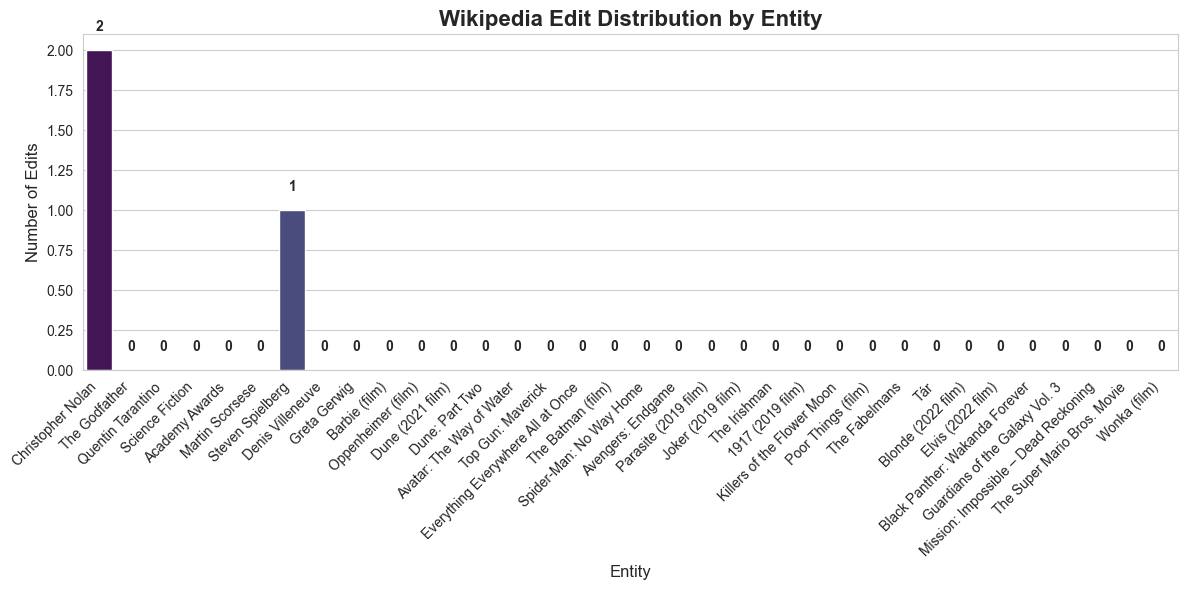


Edits per entity:
  Christopher Nolan: 2 edits
  The Godfather: 0 edits
  Quentin Tarantino: 0 edits
  Science Fiction: 0 edits
  Academy Awards: 0 edits
  Martin Scorsese: 0 edits
  Steven Spielberg: 1 edits
  Denis Villeneuve: 0 edits
  Greta Gerwig: 0 edits
  Barbie (film): 0 edits
  Oppenheimer (film): 0 edits
  Dune (2021 film): 0 edits
  Dune: Part Two: 0 edits
  Avatar: The Way of Water: 0 edits
  Top Gun: Maverick: 0 edits
  Everything Everywhere All at Once: 0 edits
  The Batman (film): 0 edits
  Spider-Man: No Way Home: 0 edits
  Avengers: Endgame: 0 edits
  Parasite (2019 film): 0 edits
  Joker (2019 film): 0 edits
  The Irishman: 0 edits
  1917 (2019 film): 0 edits
  Killers of the Flower Moon: 0 edits
  Poor Things (film): 0 edits
  The Fabelmans: 0 edits
  Tár: 0 edits
  Blonde (2022 film): 0 edits
  Elvis (2022 film): 0 edits
  Black Panther: Wakanda Forever: 0 edits
  Guardians of the Galaxy Vol. 3: 0 edits
  Mission: Impossible – Dead Reckoning: 0 edits
  The Super Ma

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a proper visualization with seaborn and matplotlib
print("=" * 60)
print("EVENT DISTRIBUTION")
print("=" * 60)

# Get counts per entity
entity_counts = {entity: m['total_edits'] for entity, m in metrics.items()}

# Create a DataFrame for easier plotting
df = pd.DataFrame(list(entity_counts.items()), columns=['Entity', 'Edit Count'])

# Set up the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Create a bar plot
ax = sns.barplot(data=df, x='Entity', y='Edit Count', palette='viridis')

# Customize the plot
plt.title('Wikipedia Edit Distribution by Entity', fontsize=16, fontweight='bold')
plt.xlabel('Entity', fontsize=12)
plt.ylabel('Number of Edits', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(df['Edit Count']):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\nEdits per entity:")
for entity, count in entity_counts.items():
    print(f"  {entity}: {count} edits")

## 12. Export Metrics Summary

Save a summary of the metrics to a JSON file.

In [60]:
# Export metrics summary
METRICS_FILE = os.path.join(OUTPUT_DIR, "metrics_summary.json")

# Convert sets to lists for JSON serialization
metrics_export = {}
for entity, m in metrics.items():
    metrics_export[entity] = {
        "total_edits": m['total_edits'],
        "bot_edits": m['bot_edits'],
        "human_edits": m['human_edits'],
        "total_bytes_changed": m['total_bytes_changed'],
        "unique_users": list(m['unique_users']),
        "unique_user_count": len(m['unique_users']),
        "alert_count": m['alert_count'],
        "last_edit": m['last_edit']
    }

with open(METRICS_FILE, 'w') as f:
    json.dump(metrics_export, f, indent=2, default=str)

print(f"Metrics summary saved to: {METRICS_FILE}")
print("\nSummary:")
print(json.dumps(metrics_export, indent=2, default=str))

Metrics summary saved to: streaming_output/metrics_summary.json

Summary:
{
  "Christopher Nolan": {
    "total_edits": 2,
    "bot_edits": 0,
    "human_edits": 2,
    "total_bytes_changed": 274,
    "unique_users": [
      "GuardianH"
    ],
    "unique_user_count": 1,
    "alert_count": 0,
    "last_edit": "2025-12-13T21:52:23.471Z"
  },
  "The Godfather": {
    "total_edits": 0,
    "bot_edits": 0,
    "human_edits": 0,
    "total_bytes_changed": 0,
    "unique_users": [],
    "unique_user_count": 0,
    "alert_count": 0,
    "last_edit": null
  },
  "Quentin Tarantino": {
    "total_edits": 0,
    "bot_edits": 0,
    "human_edits": 0,
    "total_bytes_changed": 0,
    "unique_users": [],
    "unique_user_count": 0,
    "alert_count": 0,
    "last_edit": null
  },
  "Science Fiction": {
    "total_edits": 0,
    "bot_edits": 0,
    "human_edits": 0,
    "total_bytes_changed": 0,
    "unique_users": [],
    "unique_user_count": 0,
    "alert_count": 0,
    "last_edit": null
  },
  "

## Summary

This notebook implements a complete stream processing pipeline that:

1. **Connects** to the Wikimedia EventStreams API to receive real-time Wikipedia edit events
2. **Filters** events for five IMDB-related entities (Christopher Nolan, The Godfather, Quentin Tarantino, Science Fiction, Academy Awards)
3. **Tracks metrics** including edit counts, bytes changed, unique users, and bot vs. human edits
4. **Generates alerts** for:
   - Large edits (>500 bytes changed)
   - Bot edits
   - Rapid successive edits (potential edit wars)
5. **Stores data** in two separate JSON files:
   - `wiki_events.json` - All captured events
   - `wiki_alerts.json` - Alert events requiring attention

### Output File Structure

```
streaming_output/
├── wiki_events.json      # All tracked events
├── wiki_alerts.json      # Alert events only
└── metrics_summary.json  # Aggregate metrics per entity
```

### Extending This Pipeline

This implementation can be extended to:
- Store data in a database (SQLite, PostgreSQL, MongoDB)
- Send real alerts via email, Slack, or other notification services
- Track additional entities or metrics
- Implement more sophisticated anomaly detection algorithms